In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [2]:
tf.__version__

'2.4.2'

In [4]:
path = "./Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

./Data/train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
./Data/train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
./Data/train\normal
./Data/train\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [5]:
train_path = "./Data/train"
test_path = "./Data/test"

# Helper Functions

In [6]:
# Helper-function for joining a directory and list of filenames.
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [7]:
# Helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
# Helper-function for printing confusion matrix

# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [9]:
# Helper-function for plotting example errors
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [10]:
# Function for calculating the predicted classes of the entire test-set and calling 
# the above function to plot a few examples of mis-classified images.
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    test_generator.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict(test_generator, steps=STEPS_TEST)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [11]:
# Helper-function for loading images
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

# Working on InceptionV3

In [12]:
# Set some important constants here
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 5

In [13]:
# ImageDataGenerator is needed because the dataset has no many data.
# The data augmentation can be useful to generate many augmented images from a single image

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

# test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [14]:
# save some values to be used later

cls_train = train_generator.classes
cls_test = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(class_names)
num_classes = train_generator.num_classes
print("num classes:",num_classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
num classes: 4


In [15]:
image_paths_train = path_join(train_path, train_generator.filenames)
image_paths_test = path_join(test_path, test_generator.filenames)

In [16]:
STEPS_TEST = test_generator.n / BATCH_SIZE
STEPS_TEST

63.0

In [17]:
inc_model = InceptionV3(include_top=False, weights='imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

In [18]:
inc_model.trainable = False

# Unfreeze last 30 layers except batch norm
for layer in inc_model.layers[-30:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [19]:
# Check if all layers are not trainable
for i, layer in enumerate(inc_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv2d - False
2 batch_normalization - False
3 activation - False
4 conv2d_1 - False
5 batch_normalization_1 - False
6 activation_1 - False
7 conv2d_2 - False
8 batch_normalization_2 - False
9 activation_2 - False
10 max_pooling2d - False
11 conv2d_3 - False
12 batch_normalization_3 - False
13 activation_3 - False
14 conv2d_4 - False
15 batch_normalization_4 - False
16 activation_4 - False
17 max_pooling2d_1 - False
18 conv2d_8 - False
19 batch_normalization_8 - False
20 activation_8 - False
21 conv2d_6 - False
22 conv2d_9 - False
23 batch_normalization_6 - False
24 batch_normalization_9 - False
25 activation_6 - False
26 activation_9 - False
27 average_pooling2d - False
28 conv2d_5 - False
29 conv2d_7 - False
30 conv2d_10 - False
31 conv2d_11 - False
32 batch_normalization_5 - False
33 batch_normalization_7 - False
34 batch_normalization_10 - False
35 batch_normalization_11 - False
36 activation_5 - False
37 activation_7 - False
38 activation_10 - False
39 activati

In [20]:
inc_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
model = Sequential()
model.add(inc_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

In [22]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_94 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)               2

In [23]:
checkpoint = ModelCheckpoint(filepath='./chest_CT_SCAN-InceptionV3.h5',
                            monitor='val_loss',
                            mode='auto',
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=3)

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = 50,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/20
100/100 [==============================] - 17s 143ms/step - loss: 1.5697 - acc: 0.4017 - val_loss: 1.2032 - val_acc: 0.5440
Epoch 2/20
100/100 [==============================] - 13s 132ms/step - loss: 1.1746 - acc: 0.5144 - val_loss: 1.3474 - val_acc: 0.5240
Epoch 3/20
100/100 [==============================] - 15s 152ms/step - loss: 0.9947 - acc: 0.5608 - val_loss: 1.1720 - val_acc: 0.4960
Epoch 4/20
100/100 [==============================] - 15s 153ms/step - loss: 0.9298 - acc: 0.6010 - val_loss: 0.9370 - val_acc: 0.5760
Epoch 5/20
100/100 [==============================] - 14s 135ms/step - loss: 0.8322 - acc: 0.6441 - val_loss: 1.2957 - val_acc: 0.5040
Epoch 6/20
100/100 [==============================] - 13s 133ms/step - loss: 0.6930 - acc: 0.6866 - val_loss: 1.0319 - val_acc: 0.5720
Epoch 7/20
100/100 [==============================] - 18s 185ms/step - loss: 0.8117 - acc: 0.6614 - val_loss: 1.6982 - val_acc: 0.4640
Epoch 00007: early stopping


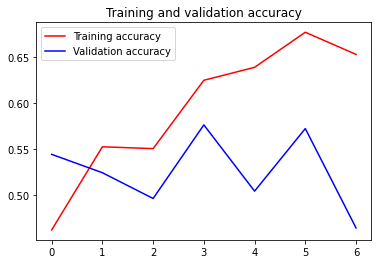

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [26]:
model.save("./model/model.h5")